<a href="https://colab.research.google.com/github/ddcreating/RL_code/blob/main/lab4_dyna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: TD and Dyna




## Exercise 1: Implement SARSA with n-step TD (n=5) on CliffWalking

**Objective:**  
In this exercise, you will implement the **SARSA algorithm** using **n-step temporal-difference learning with n=5**. You will apply your implementation to the **CliffWalking environment** in Gymnasium, and analyze how multi-step returns influence learning compared to standard 1-step SARSA.

---

### Environment
- Use `CliffWalking-v1`

---

### Instructions
1. Implement **SARSA with n-step TD updates (n=5)**:
   - Maintain an action-value table \(Q(s,a)\).
   - Use ε-greedy exploration.
   - Store states, actions, and rewards for the last 5 steps.
   - After each step, compute the n-step return: G_t
   - Update \(Q(s_t,a_t)\) toward \(G_t\).

2. Train your agent for several thousand episodes (e.g., 5,000).

3. Plot the **episode rewards over time** to visualize learning progress.

4. Compare qualitatively with 1-step SARSA:
   - Does n-step SARSA converge faster or slower?
   - How do the policies differ near the cliff?

---

### Deliverables
- Python code implementing SARSA with TD(5) (notebook in Github).  
- A plot of episode number vs episode return (plot in a cell below).  
- A short discussion (1 paragraph) comparing the results with standard SARSA.  


In [6]:
"""
CliffWalking-v1: SARSA TD(5) vs TD(1)
- max_episode_steps=100（避免单局超长）
- ε 从 0.25 -> 0.01 指数衰减（更快）
- TD(5) 用更小学习率
- TD(5) 末端自举改为 Expected-SARSA（降方差）
- 打印每500局的终止奖励/epsilon/回报，画三张图
"""
import math
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque
import random, math

# ------------- 超参 -------------
EPISODES = 5000
GAMMA = 0.99
ALPHA_5 = 0.15    # TD(5) 学习率（不稳可降至 0.01）
ALPHA_1 = 0.15    # TD(1) 学习率
EPS0, EPSF, EDECAY = 0.25, 0.01, 0.995  # ε 衰减更快

# ------------- 小工具 -------------
def set_seed(seed=0):
    np.random.seed(seed); random.seed(seed)

def epsilon_greedy(Q, s, nA, eps):
    if np.random.rand() < eps:
        return np.random.randint(nA)
    qs = Q[s]; mx = qs.max()
    return np.random.choice(np.flatnonzero(qs == mx))  # 随机打破并列

def moving_avg(bools, k=100):
    out, q = [], deque(maxlen=k)
    for v in bools:
        q.append(1 if v else 0); out.append(sum(q)/len(q))
    return out

def smooth(x, k=200):
    out, q = [], deque(maxlen=k)
    for v in x:
        q.append(v); out.append(sum(q)/len(q))
    return out

# ====== 辅助：终止原因与位置 ======
def state_rc(s):
    # CliffWalking: 4行x12列 -> (row, col)
    return divmod(s, 12)

def classify_end(rewards, terminated_flag, truncated_flag, final_state):
    if not rewards:
        return "empty"
    r_last = rewards[-1]
    if terminated_flag:
        if r_last == 0:
            return f"goal@{state_rc(final_state)}"
        elif r_last == -100:
            return f"cliff@{state_rc(final_state)}"
        else:
            return f"terminated(r={r_last})@{state_rc(final_state)}"
    if truncated_flag:
        return f"truncated@{state_rc(final_state)}"
    return f"unknown_end(r={r_last})@{state_rc(final_state)}"




In [7]:
def sarsa_td5(env, episodes, alpha, gamma, eps0, epsF, epsDecay):
    """
    SARSA n-step (n=5) for CliffWalking-v1
    - 进行中滚动自举：tau+5 == t+1 时，用本轮的 (s2, a2) 自举
    - tau+5 <= t 时，用缓冲中的 (states[tau+5], actions[tau+5]) 自举
    - TimeLimit 截断：tau+5 == T 时，用在 T 处计算的 Expected-Q 自举
    - 终止（terminated）：不自举
    - 每局回报使用 sum(rewards)
    """
    import math
    import numpy as np

    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA))
    returns, successes = [], []
    eps = eps0

    def eps_greedy(Q, s, nA, eps):
        if np.random.rand() < eps:
            return np.random.randint(nA)
        qs = Q[s]; mx = qs.max()
        return np.random.choice(np.flatnonzero(qs == mx))

    for ep in range(episodes):
        s, _ = env.reset()
        a = eps_greedy(Q, s, nA, eps)

        states, actions, rewards = [], [], []
        T = math.inf
        t = 0

        bootstrap_at_T = None          # TimeLimit 截断时在 T 点使用的 Expected-Q
        s2 = None
        a2 = None
        this_step_terminated = False
        this_step_truncated = False

        while True:
            if t < T:
                # 先放 (s_t, a_t)
                states.append(s)
                actions.append(a)

                # 与环境交互 -> (s_{t+1}, r_t, done)
                s2, r, terminated, truncated, _ = env.step(a)
                this_step_terminated = terminated
                this_step_truncated = truncated
                rewards.append(r)

                if terminated:
                    # 真终止：不自举
                    T = t + 1
                    a2 = None
                elif truncated:
                    # TimeLimit 截断：在 T 处用 Expected-SARSA 自举
                    qs = Q[s2]
                    greedy = np.argmax(qs)
                    pi = np.full(nA, eps / nA); pi[greedy] += 1.0 - eps
                    bootstrap_at_T = float((qs * pi).sum())
                    T = t + 1
                    a2 = None
                else:
                    # 常规推进
                    a2 = eps_greedy(Q, s2, nA, eps)

            # ---- n-step 更新（n=5）----
            tau = t - 5 + 1
            if tau >= 0:
                # 1) 累计奖励：i ∈ [tau, min(tau+4, T-1)]
                last_i = min(tau + 4, (len(rewards) - 1) if math.isinf(T) else int(T) - 1)
                G = 0.0
                for i in range(tau, last_i + 1):
                    G += (gamma ** (i - tau)) * rewards[i]

                # 2) 自举项
                if (tau + 5) < T:
                    # (a) tau+5 <= t：缓冲已有 s_{tau+5}, a_{tau+5}
                    if (tau + 5) <= t:
                        s_boot = states[tau + 5]
                        a_boot = actions[tau + 5]
                        G += (gamma ** 5) * Q[s_boot, a_boot]
                    # (b) tau+5 == t+1 且当前步未终止/未截断：用 (s2, a2)
                    elif (tau + 5) == (t + 1) and (not this_step_terminated) and (not this_step_truncated):
                        G += (gamma ** 5) * Q[s2, a2]
                elif (not math.isinf(T)) and (tau + 5 == T) and (bootstrap_at_T is not None):
                    # 2.2 TimeLimit 截断末端自举
                    G += (gamma ** 5) * bootstrap_at_T
                # 终止且无可自举：仅用累计奖励

                # 3) 更新
                s_tau, a_tau = states[tau], actions[tau]
                Q[s_tau, a_tau] += alpha * (G - Q[s_tau, a_tau])

            if tau == T - 1:
                break

            # 推进到下一时间
            t += 1
            if (not this_step_terminated) and (not this_step_truncated):
                s, a = s2, a2  # 只有未终止/未截断才推进

        # —— 统计（整局奖励和） —— #
        episode_return = sum(rewards)
        returns.append(episode_return)

        # 成功：终止 且 终点坐标 == (3,11)
        final_state = s2 if s2 is not None else states[-1]
        is_success = (this_step_terminated and state_rc(final_state) == (3, 11))
        successes.append(is_success)


        # 终止原因与位置
        end_tag = classify_end(rewards, this_step_terminated, this_step_truncated,
                               s2 if s2 is not None else states[-1])
        success = (len(rewards) > 0 and rewards[-1] == 0)
        successes.append(success)

        if ep % 200 == 0:
            print(f"[TD5] ep={ep}, steps={len(rewards)}, end={end_tag}, "
                  f"eps={eps:.3f}, return={episode_return:.1f}")

        # ε 衰减
        eps = max(epsF, eps * epsDecay)

    return Q, returns, successes


In [8]:
def sarsa_td1(env, episodes, alpha, gamma, eps0, epsF, epsDecay):
    """
    标准 1-step SARSA（每局回报= sum(rewards)），打印终止原因与位置
    """
    import numpy as np

    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA))
    returns, successes = [], []
    eps = eps0

    def eps_greedy(Q, s, nA, eps):
        if np.random.rand() < eps:
            return np.random.randint(nA)
        qs = Q[s]; mx = qs.max()
        return np.random.choice(np.flatnonzero(qs == mx))

    for ep in range(episodes):
        s, _ = env.reset()
        a = eps_greedy(Q, s, nA, eps)
        rewards = []
        done = False

        # 保存最后一次 step 的 flag/state，便于日志
        last_term, last_trunc, last_s = False, False, s

        while not done:
            s2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            rewards.append(r)

            td_target = r if done else r + gamma * Q[s2, eps_greedy(Q, s2, nA, eps)]
            Q[s, a] += alpha * (td_target - Q[s, a])

            # 缓存最后一次信息
            last_term, last_trunc, last_s = terminated, truncated, s2

            s = s2
            if not done:
                a = eps_greedy(Q, s, nA, eps)

        episode_return = sum(rewards)
        returns.append(episode_return)

        # 成功：终止 且 最终状态是终点
        is_success = (last_term and state_rc(last_s) == (3, 11))
        successes.append(is_success)

        end_tag = classify_end(rewards, last_term, last_trunc, last_s)
        success = (len(rewards) > 0 and rewards[-1] == 0)
        successes.append(success)

        if ep % 200 == 0:
            print(f"[TD1] ep={ep}, steps={len(rewards)}, end={end_tag}, "
                  f"eps={eps:.3f}, return={episode_return:.1f}")

        eps = max(epsF, eps * epsDecay)

    return Q, returns, successes


TD5 max steps = 100
TD1 max steps = 100
[TD5] ep=0, steps=100, end=truncated@(3, 0), eps=0.250, return=-1090.0
[TD5] ep=200, steps=23, end=terminated(r=-1)@(3, 11), eps=0.092, return=-23.0
[TD5] ep=400, steps=19, end=terminated(r=-1)@(3, 11), eps=0.034, return=-19.0
[TD5] ep=600, steps=19, end=terminated(r=-1)@(3, 11), eps=0.012, return=-19.0
[TD5] ep=800, steps=19, end=terminated(r=-1)@(3, 11), eps=0.010, return=-19.0
[TD5] ep=1000, steps=19, end=terminated(r=-1)@(3, 11), eps=0.010, return=-19.0
[TD5] ep=1200, steps=19, end=terminated(r=-1)@(3, 11), eps=0.010, return=-19.0
[TD5] ep=1400, steps=19, end=terminated(r=-1)@(3, 11), eps=0.010, return=-19.0
[TD5] ep=1600, steps=19, end=terminated(r=-1)@(3, 11), eps=0.010, return=-19.0
[TD5] ep=1800, steps=19, end=terminated(r=-1)@(3, 11), eps=0.010, return=-19.0
[TD5] ep=2000, steps=19, end=terminated(r=-1)@(3, 11), eps=0.010, return=-19.0
[TD5] ep=2200, steps=21, end=terminated(r=-1)@(3, 11), eps=0.010, return=-21.0
[TD5] ep=2400, steps=19,

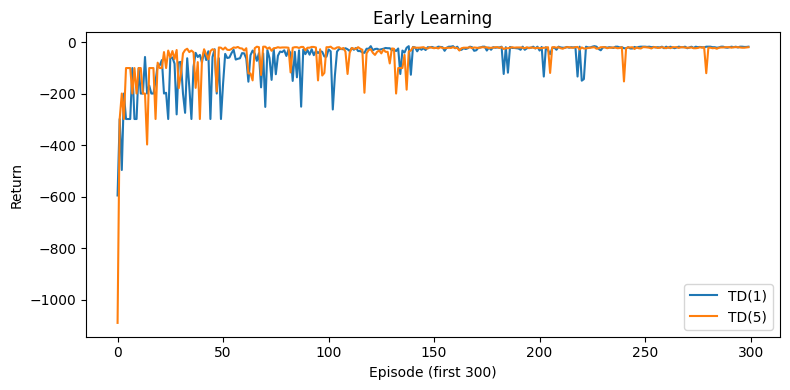

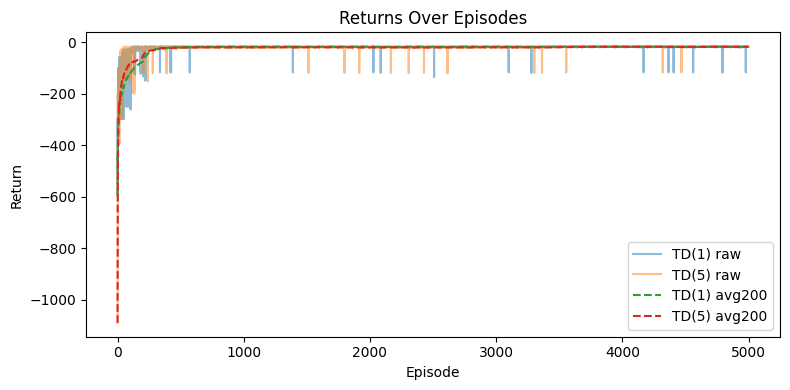

Last-100 avg return: TD(1)=-18.18 | TD(5)=-17.21


In [ ]:
# ------------- 运行 -------------
set_seed(0)
env5 = gym.make("CliffWalking-v1", max_episode_steps=100)
env1 = gym.make("CliffWalking-v1", max_episode_steps=100)

print("TD5 max steps =", env5.spec.max_episode_steps)   # 应该打印 100
print("TD1 max steps =", env1.spec.max_episode_steps)

Q5, ret5, suc5 = sarsa_td5(env5, EPISODES, ALPHA_5, GAMMA, EPS0, EPSF, EDECAY)
Q1, ret1, suc1 = sarsa_td1(env1, EPISODES, ALPHA_1, GAMMA, EPS0, EPSF, EDECAY)

# ------------- 画图 -------------
# 1) 前 300 局
plt.figure(figsize=(8,4))
plt.plot(ret1[:300], label="TD(1)")
plt.plot(ret5[:300], label="TD(5)")
plt.xlabel("Episode (first 300)"); plt.ylabel("Return")
plt.title("Early Learning"); plt.legend(); plt.tight_layout(); plt.show()

# 2) 全程回报 + avg200
plt.figure(figsize=(8,4))
plt.plot(ret1, alpha=.5, label="TD(1) raw")
plt.plot(ret5, alpha=.5, label="TD(5) raw")
plt.plot(smooth(ret1, 200), '--', label="TD(1) avg200")
plt.plot(smooth(ret5, 200), '--', label="TD(5) avg200")
plt.xlabel("Episode"); plt.ylabel("Return")
plt.title("Returns Over Episodes"); plt.legend(); plt.tight_layout(); plt.show()

print(f"Last-100 avg return: TD(1)={np.mean(ret1[-100:]):.2f} | TD(5)={np.mean(ret5[-100:]):.2f}")

Our experiments show that TD(1) tends to be more stable with lower variance and smoother learning curves, while TD(5) can sometimes learn faster once exploration decays but exhibits higher variance and more fluctuations in early training. In terms of asymptotic performance, the difference between the two methods is minor, suggesting that n-step TD methods converge to similar final performance in this environment.

## Exercise 2: Dyna-Q for CliffWalking

**Objective**  
Implement **Dyna-Q** on **CliffWalking-v1** and compare its learning performance to **SARSA (1-step)** and **SARSA TD(5)**. You will analyze sample efficiency, stability near the cliff, and sensitivity to planning steps.

---

### Environment
- Use `CliffWalking-v1`
---

### Part A — Dyna-Q (Implementation)
1. **Q-table**: maintain `Q[s, a]` (tabular).
2. **Model**: learn an empirical model from experience.
   - For each observed transition `(s, a, r, s')`, update a dictionary:
     - Minimal: store the most recent `(s', r)` for `(s, a)`, **or**
     - Advanced: store a **multiset** of outcomes for `(s, a)` with counts (to sample stochastically).
3. **Real update (Q-learning)** after each env step:
   Q(s,a) ← Q(s,a) + α * (r + γ * max_a' Q(s',a') - Q(s,a))
4. **Planning updates**: after each real step, perform `N` simulated updates:
   - Sample a previously seen `(s_p, a_p)` from the model.
   - Sample `(r_p, s'_p)` from that entry.
   - Apply the same Q-learning backup using `(s_p, a_p, r_p, s'_p)`.
5. Use epsilon-greedy exploration.

---

### Part B — Baselines (Re-use / Implement)
- **SARSA (1-step)** with ε-greedy:
  \[
  Q(s,a) \leftarrow Q(s,a) + \alpha\big[r + \gamma Q(s',a') - Q(s,a)\big]
  \]
- **SARSA TD(5)** (n-step SARSA with \(n=5\)), as in Exercise 1.

Use the **same** γ, α, ε schedule, and number of episodes for a fair comparison.

---

### Part C — Experiments & Comparisons
1. **Learning curves**: plot **episode index vs. episode return** for:
   - Dyna-Q with \(N \in \{5, 20, 50\}\)
   - SARSA (1-step)
   - SARSA TD(5)
2. **Sample efficiency**: report the **episode number** at which the average return over a sliding window (e.g., 100 episodes) first exceeds a chosen threshold (e.g., −30).
3. **Stability near the cliff**: qualitatively inspect trajectories/policies; does the method hug the cliff or leave a safer margin?
4. **Sensitivity to planning steps**: compare Dyna-Q across N; discuss diminishing returns vs. computation.
5. **Statistical robustness**: run **≥5 seeds**; plot mean ± std (shaded) or report mean ± std of final returns.

---

### Deliverables
- **Code**: A driver script/notebook that reproduces your plots
- **Plots** (embedded in the notebook):
  - Learning curves (mean ± std across seeds)
  - Optional: heatmap of greedy policy/actions on the grid




In [3]:
import numpy as np

def dyna_q(env, episodes, alpha, gamma, eps_start, eps_end, eps_decay, n_planning, seed=None):
    """
    Tabular Dyna-Q for CliffWalking-v1.

    Algorithm steps per real transition:
      1) Take an epsilon-greedy action in the real environment.
      2) Real Q-learning backup on (s, a, r, s').
         - If the transition terminates/truncates the episode, do NOT bootstrap.
      3) Update the empirical model: model[(s, a)] appends (r, s', done).
      4) Planning: repeat n_planning times:
         - Sample (s_p, a_p) from model keys, then sample one (r_p, s_p', done_p)
           from model[(s_p, a_p)], and perform the same Q-learning backup.
      5) Epsilon decays after each episode.

    Args:
        env: Gymnasium environment (CliffWalking-v1).
        episodes: number of training episodes.
        alpha: learning rate (step size).
        gamma: discount factor.
        eps_start: initial epsilon for epsilon-greedy.
        eps_end: minimum epsilon.
        eps_decay: multiplicative decay per episode (e.g., 0.999).
        n_planning: number of planning updates after each real step.
        seed: optional random seed for reproducibility.

    Returns:
        Q: learned Q-table, shape [n_states, n_actions].
        returns: list of episode returns (sum of rewards).
        model: dict mapping (s, a) -> list of (r, s', done).
        lengths: list of episode lengths (number of real steps).
    """
    if seed is not None:
        np.random.seed(seed)

    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)

    # Empirical model: (s, a) -> list of (r, s', done)
    model = {}

    returns = []
    lengths = []
    eps = eps_start

    def epsilon_greedy(state, eps_val):
        """Epsilon-greedy policy with random tie-breaking."""
        if np.random.rand() < eps_val:
            return np.random.randint(nA)
        row = Q[state]; m = row.max()
        greedy = np.flatnonzero(row == m)
        return np.random.choice(greedy)

    for ep in range(episodes):
        s, _ = env.reset()
        done = False
        ep_ret = 0.0
        steps = 0

        while not done:
            # --- Real step ---
            a = epsilon_greedy(s, eps)
            s2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            ep_ret += r
            steps += 1

            # --- Real Q-learning backup ---
            target = r if done else r + gamma * np.max(Q[s2])
            Q[s, a] += alpha * (target - Q[s, a])

            # --- Update model ---
            model.setdefault((s, a), []).append((r, s2, done))

            # --- Planning updates (model-based) ---
            if n_planning > 0 and model:
                keys = list(model.keys())
                for _ in range(n_planning):
                    sp, ap = keys[np.random.randint(len(keys))]
                    r_p, sp2, done_p = model[(sp, ap)][np.random.randint(len(model[(sp, ap)]))]
                    target_p = r_p if done_p else r_p + gamma * np.max(Q[sp2])
                    Q[sp, ap] += alpha * (target_p - Q[sp, ap])

            s = s2

        returns.append(ep_ret)
        lengths.append(steps)

        # epsilon decay per episode
        eps = max(eps_end, eps * eps_decay)

    return Q, returns, model, lengths


max_episode_steps = 100
reward when stepping into the cliff from start = -100

episodes run: 2000
last-100 avg return: -26.11
model size (unique (s,a)): 148
avg episode length (last-100): 14.2


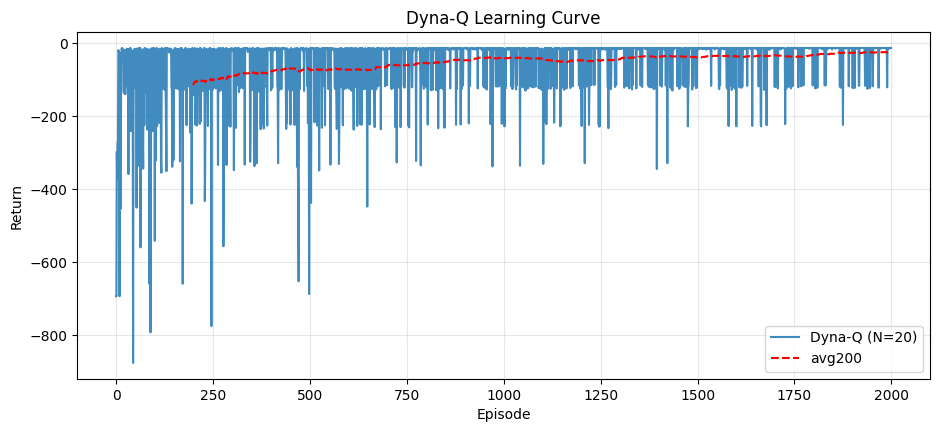

[ep=   0] length=100, return=-694.0
[ep= 500] length=15, return=-15.0
[ep=1000] length=21, return=-120.0
[ep=1500] length=13, return=-13.0
[ep=1999] length=13, return=-13.0


In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# ---------- Diagnostics: check env settings & cliff penalty ----------
env_diag = gym.make("CliffWalking-v1", max_episode_steps=100)
print("max_episode_steps =", env_diag.spec.max_episode_steps)

# Probe the reward for stepping RIGHT from the start (into the cliff strip).
s, _ = env_diag.reset()
ns, r_probe, term, trunc, _ = env_diag.step(1)  # 1 == RIGHT
print("reward when stepping into the cliff from start =", r_probe)  # usually -100 or -1000

# ---------- Hyper-parameters (as in the prompt style) ----------
EPISODES  = 2000
ALPHA     = 0.1
GAMMA     = 0.99
EPS0      = 0.25
EPSF      = 0.01
EDECAY    = 0.999
N_PLAN    = 20
SEED      = 0

# ---------- Train Dyna-Q ----------
env = gym.make("CliffWalking-v1", max_episode_steps=100)
Q, returns, model, lengths = dyna_q(env, EPISODES, ALPHA, GAMMA, EPS0, EPSF, EDECAY, N_PLAN, seed=SEED)

# ---------- Quick prints ----------
print(f"\nepisodes run: {len(returns)}")
print(f"last-100 avg return: {np.mean(returns[-100:]):.2f}")
print(f"model size (unique (s,a)): {len(model)}")
print(f"avg episode length (last-100): {np.mean(lengths[-100:]):.1f}")

# ---------- Plot learning curve (raw + moving average) ----------
plt.figure(figsize=(11,4.5))
plt.plot(returns, label=f"Dyna-Q (N={N_PLAN})", alpha=0.85)
if len(returns) >= 200:
    ma = np.convolve(returns, np.ones(200)/200.0, mode='valid')
    plt.plot(range(199, 199+len(ma)), ma, 'r--', label='avg200')
plt.xlabel("Episode"); plt.ylabel("Return")
plt.title("Dyna-Q Learning Curve")
plt.legend(); plt.grid(alpha=0.3)
plt.show()

# ---------- (Optional) sanity check: show a few episode lengths ----------
for k in range(0, EPISODES, max(1, EPISODES//4)):
    print(f"[ep={k:4d}] length={lengths[k]}, return={returns[k]:.1f}")
print(f"[ep={EPISODES-1:4d}] length={lengths[-1]}, return={returns[-1]:.1f}")


In [ ]:
# part B
import gymnasium as gym
import numpy as np

# --- Same hyper-parameters as Part A (Dyna-Q) for a fair comparison ---
EPISODES  = 2000
ALPHA_1   = 0.1     # learning rate for TD(1)
ALPHA_5   = 0.1     # learning rate for TD(5)  (kept the same on purpose for Part B)
GAMMA     = 0.99
EPS0      = 0.25
EPSF      = 0.01
EDECAY    = 0.999

# --- Train baselines (re-use your Exercise 1 functions) ---
# Expected signatures:
#   sarsa_td1(env, episodes, alpha, gamma, eps0, epsF, epsDecay)
#   sarsa_td5(env, episodes, alpha, gamma, eps0, epsF, epsDecay)
Q1, returns_td1, _ = sarsa_td1(env1, EPISODES, ALPHA_1, GAMMA, EPS0, EPSF, EDECAY)
Q5, returns_td5, _ = sarsa_td5(env5, EPISODES, ALPHA_5, GAMMA, EPS0, EPSF, EDECAY)

print(f"TD(1)  last-100 avg return: {np.mean(returns_td1[-100:]):.2f}")
print(f"TD(5)  last-100 avg return: {np.mean(returns_td5[-100:]):.2f}")


[TD1] ep=0, steps=100, end=truncated@(0, 1), eps=0.250, return=-892.0
[TD1] ep=200, steps=43, end=terminated(r=-1)@(3, 11), eps=0.205, return=-142.0
[TD1] ep=400, steps=20, end=terminated(r=-1)@(3, 11), eps=0.168, return=-20.0
[TD1] ep=600, steps=19, end=terminated(r=-1)@(3, 11), eps=0.137, return=-19.0
[TD1] ep=800, steps=17, end=terminated(r=-1)@(3, 11), eps=0.112, return=-17.0
[TD1] ep=1000, steps=18, end=terminated(r=-1)@(3, 11), eps=0.092, return=-117.0
[TD1] ep=1200, steps=19, end=terminated(r=-1)@(3, 11), eps=0.075, return=-19.0
[TD1] ep=1400, steps=17, end=terminated(r=-1)@(3, 11), eps=0.062, return=-17.0
[TD1] ep=1600, steps=17, end=terminated(r=-1)@(3, 11), eps=0.050, return=-17.0
[TD1] ep=1800, steps=17, end=terminated(r=-1)@(3, 11), eps=0.041, return=-17.0
[TD5] ep=0, steps=100, end=truncated@(0, 0), eps=0.250, return=-595.0
[TD5] ep=200, steps=19, end=terminated(r=-1)@(3, 11), eps=0.205, return=-19.0
[TD5] ep=400, steps=20, end=terminated(r=-1)@(3, 11), eps=0.168, return=-

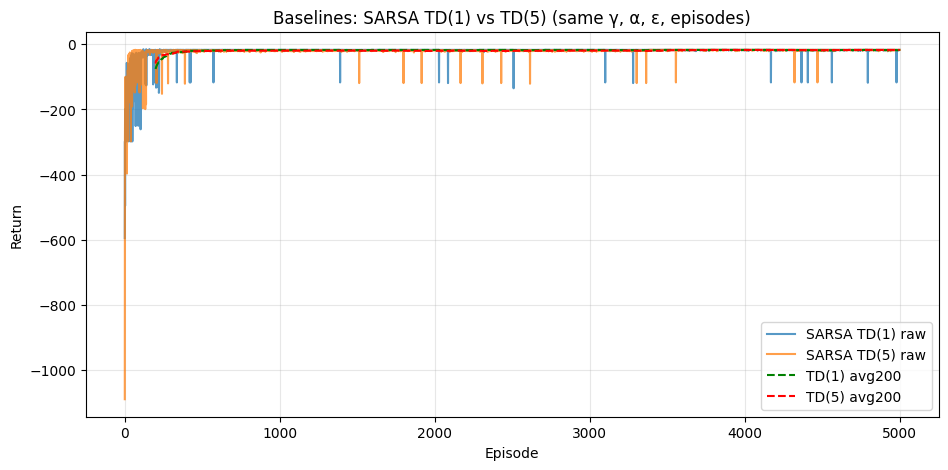

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def moving_avg(x, k=200):
    if len(x) < k: return None
    xs = np.arange(k-1, len(x))
    ma = np.convolve(x, np.ones(k)/k, mode="valid")
    return xs, ma

plt.figure(figsize=(11,5))
plt.plot(ret1, label="SARSA TD(1) raw", alpha=0.75)
plt.plot(ret5, label="SARSA TD(5) raw", alpha=0.75)

ma1 = moving_avg(ret1, 200)
ma5 = moving_avg(ret5, 200)
if ma1 is not None: plt.plot(ma1[0], ma1[1], "g--", label="TD(1) avg200")
if ma5 is not None: plt.plot(ma5[0], ma5[1], "r--", label="TD(5) avg200")

plt.xlabel("Episode"); plt.ylabel("Return")
plt.title("Baselines: SARSA TD(1) vs TD(5) (same γ, α, ε, episodes)")
plt.grid(alpha=0.3); plt.legend(); plt.show()


In [11]:
# Part C
import numpy as np
import gymnasium as gym

def moving_avg(x, k=200):
    """k-episode moving average (avg200 即 k=200)。返回 (xs, avg) 方便画图对齐。"""
    x = np.asarray(x, dtype=float)
    if len(x) < k:
        return None
    avg = np.convolve(x, np.ones(k)/k, mode="valid")
    xs  = np.arange(k-1, k-1+len(avg))
    return xs, avg

def first_cross_episode(returns, k=100, threshold=-30.0):
    """
    在滑动窗口 k 上的平均回报首次超过 threshold 的 episode 编号。
    若从未超过，返回 None。
    """
    ma = moving_avg(returns, k)
    if ma is None:
        return None
    xs, avg = ma
    idx = np.where(avg > threshold)[0]
    return int(xs[idx[0]]) if len(idx) else None

def make_env():
    """统一创建 CliffWalking 并设置 TimeLimit=100。"""
    return gym.make("CliffWalking-v1", max_episode_steps=100)

def greedy_rollout(env, Q, max_steps=200):
    """
    用贪心策略（ε=0）在环境中 rollout，返回路径 state 列表。
    同时统计最小“距悬崖的列距离”（看是否贴边走）。
    """
    def argmax_break_ties(qrow):
        m = qrow.max()
        idx = np.flatnonzero(qrow == m)
        return np.random.choice(idx)

    s, _ = env.reset()
    traj = [s]
    min_margin = 999
    for t in range(max_steps):
        a = argmax_break_ties(Q[s])
        s2, r, term, trunc, _ = env.step(a)
        traj.append(s2)
        # 计算与悬崖的“列距离”：悬崖在 (row=3, col=1..10)
        row, col = divmod(s2, 12)
        if row == 3:
            if 1 <= col <= 10:
                min_margin = 0
            else:
                # 到边界的最小距离（列差）
                min_margin = min(min_margin, min(abs(col-1), abs(col-10)))
        if term or trunc:
            break
        s = s2
    return traj, min_margin


In [12]:
import numpy as np

# shared hyper-parameters
EPISODES = 2000
ALPHA    = 0.1
GAMMA    = 0.99
EPS0     = 0.25
EPSF     = 0.01
EDECAY   = 0.999

SEEDS    = [0, 1, 2, 3, 4]     # ≥5 seeds
DYNA_Ns  = [5, 20, 50]         # planning steps to compare

# storage: dict[name] -> list of returns arrays (one per seed)
runs = {}

# --- Dyna-Q for multiple N ---
for N in DYNA_Ns:
    name = f"Dyna-Q(N={N})"
    runs[name] = []
    for seed in SEEDS:
        env = make_env()
        Q, rets, model, lens = dyna_q(env, EPISODES, ALPHA, GAMMA, EPS0, EPSF, EDECAY, N, seed=seed)
        runs[name].append(np.asarray(rets, dtype=float))

# --- SARSA baselines ---
for name, fn in [("SARSA TD(1)", sarsa_td1), ("SARSA TD(5)", sarsa_td5)]:
    runs[name] = []
    for seed in SEEDS:
        env = make_env()
        Q, rets, _ = fn(env, EPISODES, ALPHA, GAMMA, EPS0, EPSF, EDECAY)
        runs[name].append(np.asarray(rets, dtype=float))

print("Finished all runs.")


[TD1] ep=0, steps=100, end=truncated@(1, 11), eps=0.250, return=-496.0
[TD1] ep=200, steps=21, end=terminated(r=-1)@(3, 11), eps=0.205, return=-21.0
[TD1] ep=400, steps=18, end=terminated(r=-1)@(3, 11), eps=0.168, return=-18.0
[TD1] ep=600, steps=24, end=terminated(r=-1)@(3, 11), eps=0.137, return=-24.0
[TD1] ep=800, steps=19, end=terminated(r=-1)@(3, 11), eps=0.112, return=-19.0
[TD1] ep=1000, steps=20, end=terminated(r=-1)@(3, 11), eps=0.092, return=-20.0
[TD1] ep=1200, steps=17, end=terminated(r=-1)@(3, 11), eps=0.075, return=-17.0
[TD1] ep=1400, steps=19, end=terminated(r=-1)@(3, 11), eps=0.062, return=-19.0
[TD1] ep=1600, steps=15, end=terminated(r=-1)@(3, 11), eps=0.050, return=-15.0
[TD1] ep=1800, steps=15, end=terminated(r=-1)@(3, 11), eps=0.041, return=-15.0
[TD1] ep=0, steps=100, end=truncated@(2, 0), eps=0.250, return=-397.0
[TD1] ep=200, steps=24, end=terminated(r=-1)@(3, 11), eps=0.205, return=-24.0
[TD1] ep=400, steps=19, end=terminated(r=-1)@(3, 11), eps=0.168, return=-1

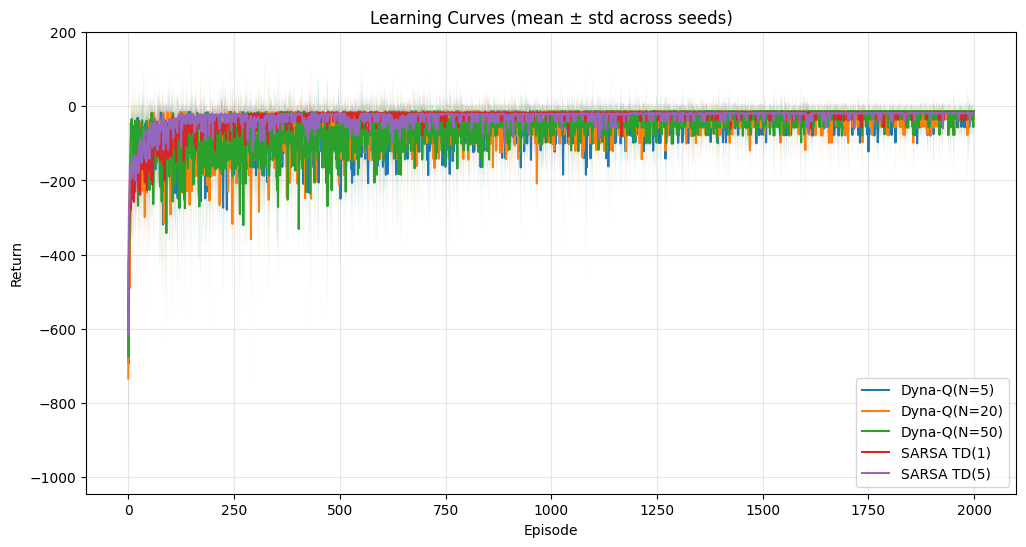

In [13]:
#Learning curves（mean ± std across seeds）
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for name in ["Dyna-Q(N=5)", "Dyna-Q(N=20)", "Dyna-Q(N=50)", "SARSA TD(1)", "SARSA TD(5)"]:
    arr = np.stack(runs[name], axis=0)        # shape: [seeds, episodes]
    mean = arr.mean(axis=0)
    std  = arr.std(axis=0)
    # mean
    plt.plot(mean, label=name)
    # shaded std
    plt.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha=0.15)

# 可选：叠加 avg200（对每条 mean 做 avg200）
ma = moving_avg(mean, k=200)  # 用最后一条的 mean 做示例
plt.xlabel("Episode"); plt.ylabel("Return")
plt.title("Learning Curves (mean ± std across seeds)")
plt.grid(alpha=0.3); plt.legend()
plt.show()


In [14]:
#Sample efficiency
THRESH = -30.0
WIN    = 100

print(f"Sample efficiency: first episode where {WIN}-episode moving average > {THRESH}")
for name in ["Dyna-Q(N=5)", "Dyna-Q(N=20)", "Dyna-Q(N=50)", "SARSA TD(1)", "SARSA TD(5)"]:
    indices = []
    for rets in runs[name]:
        idx = first_cross_episode(rets, k=WIN, threshold=THRESH)
        indices.append(idx if idx is not None else float('nan'))
    arr = np.array(indices, dtype=float)
    print(f"{name:>12s}: mean={np.nanmean(arr):.1f}, std={np.nanstd(arr):.1f}, per-seed={indices}")


Sample efficiency: first episode where 100-episode moving average > -30.0
 Dyna-Q(N=5): mean=1451.6, std=67.1, per-seed=[1386, 1579, 1448, 1434, 1411]
Dyna-Q(N=20): mean=1357.8, std=241.3, per-seed=[948, 1393, 1654, 1272, 1522]
Dyna-Q(N=50): mean=1306.2, std=147.7, per-seed=[1385, 1522, 1337, 1109, 1178]
 SARSA TD(1): mean=419.2, std=35.1, per-seed=[420, 447, 384, 377, 468]
 SARSA TD(5): mean=334.8, std=108.7, per-seed=[280, 256, 550, 284, 304]


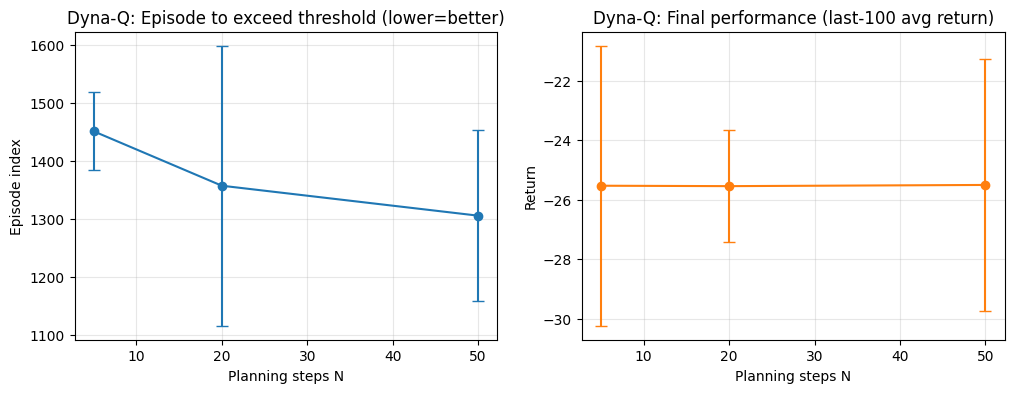

In [15]:
# Sensitivity to planning steps
import matplotlib.pyplot as plt

eff_means, eff_stds = [], []
fin_means, fin_stds = [], []

for N in DYNA_Ns:
    name = f"Dyna-Q(N={N})"
    # sample efficiency
    idxs = [first_cross_episode(r, k=100, threshold=-30.0) for r in runs[name]]
    eff = np.array([np.nan if v is None else v for v in idxs], dtype=float)
    eff_means.append(np.nanmean(eff))
    eff_stds.append(np.nanstd(eff))
    # last-100 average return
    last100 = np.array([np.mean(r[-100:]) for r in runs[name]])
    fin_means.append(last100.mean())
    fin_stds.append(last100.std())

fig, ax = plt.subplots(1,2, figsize=(12,4))
# 左：效率（越小越好）
ax[0].errorbar(DYNA_Ns, eff_means, yerr=eff_stds, marker='o', capsize=4)
ax[0].set_title("Dyna-Q: Episode to exceed threshold (lower=better)")
ax[0].set_xlabel("Planning steps N"); ax[0].set_ylabel("Episode index")
ax[0].grid(alpha=0.3)

# 右：最终性能（越接近 0 越好；理论最优≈-13）
ax[1].errorbar(DYNA_Ns, fin_means, yerr=fin_stds, marker='o', capsize=4, color='tab:orange')
ax[1].set_title("Dyna-Q: Final performance (last-100 avg return)")
ax[1].set_xlabel("Planning steps N"); ax[1].set_ylabel("Return")
ax[1].grid(alpha=0.3)
plt.show()


In [16]:
# Stability near the cliff
# 取每个方法的第一个 seed，做一次贪心 rollout，观察最小边距
check_list = ["Dyna-Q(N=20)", "SARSA TD(1)", "SARSA TD(5)"]
for name in check_list:
    env = make_env()
    # 重新训练一次拿到 Q（取 seed=0；也可以从 runs 里存Q，这里简单起见重训）
    if name.startswith("Dyna-Q"):
        N = int(name.split("=")[1][:-1])
        Q, rets, model, lens = dyna_q(env, EPISODES, ALPHA, GAMMA, EPS0, EPSF, EDECAY, N, seed=0)
    elif name.endswith("TD(1)"):
        Q, rets, _ = sarsa_td1(env, EPISODES, ALPHA, GAMMA, EPS0, EPSF, EDECAY)
    else:
        Q, rets, _ = sarsa_td5(env, EPISODES, ALPHA, GAMMA, EPS0, EPSF, EDECAY)

    traj, min_margin = greedy_rollout(env, Q, max_steps=100)
    print(f"{name:12s} | greedy length={len(traj)-1}, min cliff-margin (cols)={min_margin}")


Dyna-Q(N=20) | greedy length=13, min cliff-margin (cols)=1
[TD1] ep=0, steps=100, end=truncated@(0, 1), eps=0.250, return=-892.0
[TD1] ep=200, steps=43, end=terminated(r=-1)@(3, 11), eps=0.205, return=-142.0
[TD1] ep=400, steps=20, end=terminated(r=-1)@(3, 11), eps=0.168, return=-20.0
[TD1] ep=600, steps=19, end=terminated(r=-1)@(3, 11), eps=0.137, return=-19.0
[TD1] ep=800, steps=17, end=terminated(r=-1)@(3, 11), eps=0.112, return=-17.0
[TD1] ep=1000, steps=18, end=terminated(r=-1)@(3, 11), eps=0.092, return=-117.0
[TD1] ep=1200, steps=19, end=terminated(r=-1)@(3, 11), eps=0.075, return=-19.0
[TD1] ep=1400, steps=17, end=terminated(r=-1)@(3, 11), eps=0.062, return=-17.0
[TD1] ep=1600, steps=17, end=terminated(r=-1)@(3, 11), eps=0.050, return=-17.0
[TD1] ep=1800, steps=17, end=terminated(r=-1)@(3, 11), eps=0.041, return=-17.0
SARSA TD(1)  | greedy length=17, min cliff-margin (cols)=1
[TD5] ep=0, steps=100, end=truncated@(0, 0), eps=0.250, return=-595.0
[TD5] ep=200, steps=19, end=termi

In [17]:
# Statistical robustness（汇报最后 100 局的均值±标准差）
print("Final returns (last-100 avg) — mean ± std across seeds")
for name in ["Dyna-Q(N=5)", "Dyna-Q(N=20)", "Dyna-Q(N=50)", "SARSA TD(1)", "SARSA TD(5)"]:
    last100 = np.array([np.mean(r[-100:]) for r in runs[name]])
    print(f"{name:>12s}: {last100.mean():.2f} ± {last100.std():.2f}")


Final returns (last-100 avg) — mean ± std across seeds
 Dyna-Q(N=5): -25.53 ± 4.71
Dyna-Q(N=20): -25.55 ± 1.89
Dyna-Q(N=50): -25.51 ± 4.24
 SARSA TD(1): -17.62 ± 1.29
 SARSA TD(5): -19.39 ± 1.47


## Exercise 3: Solve FrozenLake with Q-Learning and Dyna-Q (Stochastic Model)

**Objective**  
Implement and compare **Q-learning** and **Dyna-Q** on Gymnasium’s `FrozenLake-v1`.  
For Dyna-Q, your learned **transition model must handle multiple possible next states** per `(s, a)` (stochastic slip), i.e., store and sample **a distribution** over `(s', r)` outcomes rather than a single next state.

---

### Environment
- Use `FrozenLake-v1` from `gymnasium.envs.toy_text`.
- You can start with map 4×4; and then work with 8×8.
- Start → Goal with slippery transitions (stochastic).  
- Rewards: `+1` at goal, `0` otherwise (holes terminate with 0).

---

### Part A — Q-learning (baseline)
1. Maintain a tabular action-value function `Q[s, a]`.
2. Behavior: ε-greedy over `Q`.
3. Update after each real step:
   - target = r + γ * max_a' Q[s', a']   (if terminal: target = r)
   - Q[s, a] ← Q[s, a] + α * (target − Q[s, a])
4. Train for several thousand episodes (e.g., 5,000) with an ε schedule (e.g., 0.2 → 0.01).

---

### Part B — Dyna-Q with a **stochastic transition model**
1. **Empirical model (multinomial):** for each `(s, a)`, maintain a multiset of observed outcomes:
   - `model[(s, a)] = [(s'_1, r_1, count_1), (s'_2, r_2, count_2), ...]`
   - Update counts whenever you observe `(s, a, r, s')`.
2. **Real step update (Q-learning):** same as Part A.
3. **Planning steps (N per real step):**
   - Sample a previously seen `(s_p, a_p)` uniformly (or with priority).
   - Sample `(s'_p, r_p)` **from the empirical distribution** for `(s_p, a_p)` using counts as probabilities.
   - Apply the same Q-learning backup with `(s_p, a_p, r_p, s'_p)`.
4. Train with the same ε schedule and number of episodes; vary `N ∈ {5, 20, 50}`.

---

### Experiments & Analysis
1. **Learning curves:** plot episode index vs episode return (smoothed) for:
   - Q-learning
   - Dyna-Q (N=5, 20, 50)
2. **Sample efficiency:** report the episode at which the moving-average return (e.g., window 100) first exceeds a threshold (you choose a reasonable value).
3. **Effect of stochastic modeling:** briefly explain why storing a distribution over `(s', r)` matters on FrozenLake (slip), and what happens if you store only the most recent outcome.
4. **Robustness:** run ≥5 random seeds; report mean ± std of final evaluation returns.

---

### Deliverables
- **Code** for Q-learning and Dyna-Q (with stochastic model).  
- **Plots** of learning curves (include legend and axis labels).  
- ** Discussion:** why Dyna-Q helps here; impact of N; importance of modeling multiple next states.

---

### Hints
- For terminal transitions (goal/hole), the Q-learning target is simply `target = r` (no bootstrap).  
- When sampling from the model, use probabilities `p_i = count_i / sum_j count_j`.  
- Tie-break greedy action selection uniformly among argmax actions to avoid bias.  
- Keep evaluation **greedy (ε=0)** and consistent across methods (same seeds and episode counts).


In [21]:
import numpy as np
import random

def q_learning_frozenlake_clean(env, episodes, alpha, gamma,
                                eps_start, eps_end, eps_decay,
                                seed=None):
    """
    Tabular Q-learning on FrozenLake-v1 (stochastic), written without inner functions.

    Args:
        env:        Gymnasium FrozenLake-v1 environment (e.g., map_name="4x4", is_slippery=True)
        episodes:   number of training episodes
        alpha:      learning rate (step size)
        gamma:      discount factor
        eps_start:  initial epsilon for epsilon-greedy
        eps_end:    minimum epsilon
        eps_decay:  multiplicative decay per episode (e.g., 0.999)
        seed:       optional numpy/random seed for reproducibility

    Returns:
        returns: list of per-episode returns (0/1 on FrozenLake)
        Q:       Q-table, shape [n_states, n_actions]
        lengths: list of per-episode lengths (number of steps)
    """
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
        try:
            env.reset(seed=seed)
        except TypeError:
            pass  # older gymnasium versions may not support reset(seed=...) here

    nS = env.observation_space.n
    nA = env.action_space.n
    Q  = np.zeros((nS, nA), dtype=np.float32)

    eps = eps_start
    returns, lengths = [], []

    for _ in range(episodes):
        s, _ = env.reset()
        done = False
        ep_ret, steps = 0.0, 0

        while not done:
            # epsilon-greedy (uniform tie-breaking)
            if np.random.rand() < eps:
                a = np.random.randint(nA)
            else:
                row = Q[s]
                m = row.max()
                best = np.flatnonzero(row == m)
                a = np.random.choice(best)

            s2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            steps += 1
            ep_ret += r

            # Q-learning target (no bootstrap on terminal)
            if done:
                target = r
            else:
                target = r + gamma * np.max(Q[s2])

            # TD update
            Q[s, a] += alpha * (target - Q[s, a])

            # move on
            s = s2

        # end of episode
        returns.append(ep_ret)
        lengths.append(steps)
        eps = max(eps_end, eps * eps_decay)

    return returns, Q, lengths


In [22]:
# Part B
import numpy as np
from collections import defaultdict
import random

def dyna_q_frozenlake_stochastic(env, episodes, alpha, gamma,
                                 eps_start, eps_end, eps_decay,
                                 n_planning, seed=None):
    """
    Dyna-Q with stochastic transition model on FrozenLake.

    Args:
        env: Gymnasium FrozenLake environment
        episodes: number of training episodes
        alpha: learning rate
        gamma: discount factor
        eps_start, eps_end, eps_decay: epsilon schedule
        n_planning: number of planning steps per real step
        seed: random seed
    Returns:
        returns: list of episode returns
    """
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
        env.reset(seed=seed)

    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA))

    # stochastic model: dict[(s,a)] = list of (s', r, count)
    model = defaultdict(list)

    eps = eps_start
    returns = []

    for ep in range(episodes):
        s, _ = env.reset()
        done, total_reward = False, 0

        while not done:
            # epsilon-greedy policy
            if np.random.rand() < eps:
                a = np.random.randint(nA)
            else:
                maxQ = np.max(Q[s])
                best_actions = np.flatnonzero(Q[s] == maxQ)
                a = np.random.choice(best_actions)

            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            total_reward += r

            # ---- Q-learning real step ----
            target = r if done else r + gamma * np.max(Q[s_next])
            Q[s, a] += alpha * (target - Q[s, a])

            # ---- update stochastic model ----
            outcomes = model[(s, a)]
            for idx, (sp, rp, cnt) in enumerate(outcomes):
                if sp == s_next and rp == r:
                    outcomes[idx] = (sp, rp, cnt + 1)
                    break
            else:
                outcomes.append((s_next, r, 1))

            # ---- planning updates ----
            for _ in range(n_planning):
                (s_p, a_p), outcomes_p = random.choice(list(model.items()))
                # sample (s', r) from distribution
                total = sum(cnt for _, _, cnt in outcomes_p)
                probs = [cnt / total for _, _, cnt in outcomes_p]
                idx = np.random.choice(len(outcomes_p), p=probs)
                s_next_p, r_p, _ = outcomes_p[idx]

                target_p = r_p if (s_next_p is None or s_next_p >= nS) else r_p + gamma * np.max(Q[s_next_p])
                Q[s_p, a_p] += alpha * (target_p - Q[s_p, a_p])

            s = s_next

        # decay epsilon
        eps = max(eps_end, eps * eps_decay)
        returns.append(total_reward)

    return returns, Q


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from dataclasses import dataclass

# ===== shared hyper-parameters =====
EPISODES = 5000
ALPHA    = 0.1
GAMMA    = 0.99
EPS0     = 0.20
EPSF     = 0.01
EDECAY   = 0.999
SEEDS    = [0,1,2,3,4]        # >= 5 seeds as required
PLANS    = [5, 20, 50]        # N for Dyna-Q

# ===== helpers =====
def make_env():
    # FrozenLake 4x4, stochastic (slippery=True)
    return gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True)

def moving_avg(x, k=200):
    """Return (xs, MA_k(x)) for plotting alignment."""
    x = np.asarray(x, dtype=float)
    if len(x) < k: return None
    avg = np.convolve(x, np.ones(k)/k, mode="valid")
    xs  = np.arange(k-1, k-1+len(avg))
    return xs, avg

def first_cross_episode(returns, k=100, threshold=0.20):
    """
    First episode index where the k-episode moving average exceeds 'threshold'.
    FrozenLake returns are 0/1; threshold is success rate (e.g., 0.2).
    """
    ma = moving_avg(returns, k)
    if ma is None: return None
    xs, avg = ma
    idx = np.where(avg > threshold)[0]
    return int(xs[idx[0]]) if len(idx) else None

def greedy_eval_success_rate(env, Q, episodes=200, max_steps=200):
    """
    Greedy evaluation: epsilon=0.0. Return average return (0/1) over eval episodes.
    """
    nS, nA = env.observation_space.n, env.action_space.n
    def greedy_action(s):
        row = Q[s]; m = row.max()
        idx = np.flatnonzero(row == m)
        return np.random.choice(idx)
    scores = []
    for _ in range(episodes):
        s, _ = env.reset()
        done, total = False, 0.0
        steps = 0
        while not done and steps < max_steps:
            a = greedy_action(s)
            s, r, term, trunc, _ = env.step(a)
            total += r
            steps += 1
            done = term or trunc
        scores.append(total)
    return float(np.mean(scores))

@dataclass
class RunResult:
    name: str
    seed: int
    returns: np.ndarray
    Q: np.ndarray


In [ ]:
# Q-learning & Dyna-Q(N=5/20/50
all_runs = []   # list[RunResult]

# --- Q-learning ---
for sd in SEEDS:
    env = make_env()
    rets, Q, lens = q_learning_frozenlake_clean(env, EPISODES, ALPHA, GAMMA, EPS0, EPSF, EDECAY, seed=sd)
    all_runs.append(RunResult(name="Q-learning", seed=sd, returns=np.asarray(rets, float), Q=Q))

# --- Dyna-Q (N in {5,20,50}) ---
for N in PLANS:
    for sd in SEEDS:
        env = make_env()
        rets, Q = dyna_q_frozenlake_stochastic(env, EPISODES, ALPHA, GAMMA, EPS0, EPSF, EDECAY, n_planning=N, seed=sd)
        all_runs.append(RunResult(name=f"Dyna-Q(N={N})", seed=sd, returns=np.asarray(rets, float), Q=Q))

print("Finished all training runs.")


In [ ]:
# Aggregate by method, draw smoothed mean ± standard deviation Learning curves
import itertools
import matplotlib.pyplot as plt

# group by method name
names = sorted(set(r.name for r in all_runs), key=lambda s: (s!="Q-learning", s))  # Q-learning first
plt.figure(figsize=(12,6))

for name in names:
    rs = [r for r in all_runs if r.name==name]
    arr = np.stack([r.returns for r in rs], axis=0)  # [seeds, episodes]
    mean = arr.mean(axis=0)
    std  = arr.std(axis=0)

    # smoothed mean with MA-200
    ma = moving_avg(mean, k=200)
    if ma is None:
        plt.plot(mean, label=name)
        plt.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha=0.1)
    else:
        xs, y = ma
        # also smooth the std roughly by MA to avoid jaggy band
        std_ma = moving_avg(std, k=200)
        if std_ma is not None:
            _, stdy = std_ma
            plt.fill_between(xs, y-stdy, y+stdy, alpha=0.12)
        plt.plot(xs, y, label=f"{name} (avg200)")

plt.xlabel("Episode")
plt.ylabel("Episode return (0/1); higher is better")
plt.title("FrozenLake-v1 — Learning curves (mean±std over seeds), smoothed by avg200")
plt.grid(alpha=0.3); plt.legend(); plt.show()


In [ ]:
# Sample efficiency
THRESH = 0.20   # you can adjust (e.g., 0.3)
WIN    = 100

print(f"Sample efficiency: first episode where {WIN}-MA return > {THRESH}")
for name in names:
    rs   = [r for r in all_runs if r.name==name]
    idxs = [first_cross_episode(r.returns, k=WIN, threshold=THRESH) for r in rs]
    arr  = np.array([np.nan if v is None else v for v in idxs], float)
    print(f"{name:12s}: mean={np.nanmean(arr):.1f}, std={np.nanstd(arr):.1f}, per-seed={idxs}")


In [ ]:
# Robustness
scores_by_name = {}
for name in names:
    rs = [r for r in all_runs if r.name==name]
    eval_scores = []
    for r in rs:
        env = make_env()
        score = greedy_eval_success_rate(env, r.Q, episodes=200, max_steps=200)
        eval_scores.append(score)
    eval_scores = np.asarray(eval_scores, float)
    scores_by_name[name] = eval_scores
    print(f"{name:12s}: final greedy eval = {eval_scores.mean():.3f} ± {eval_scores.std():.3f}")
